In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets

In [ ]:
from google.colab import drive
# Mount Google Drive
drive.mount('/content/gdrive')

In [ ]:
data_transforms = {

    'Train' : transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'Validate': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

    ])
}

In [ ]:
# don't
#extract dataset
import zipfile
import os

#MSI_MSS
ZIP_PATH = "/content/gdrive/MyDrive/MSI_MSS_zips/Train/MSI.zip"
IMAGE_FOLDER = "/content/gdrive/MyDrive/MSI_MSS_2/Train/"

# Ensure that the extraction folder exists
if not os.path.exists(IMAGE_FOLDER):
    os.makedirs(IMAGE_FOLDER)

# Open the zip file and extract its contents without creating a new folder
with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
    for file_info in zip_ref.infolist():
        print(f"Extracting: {file_info.filename}")
        zip_ref.extract(file_info, path=IMAGE_FOLDER)

In [ ]:
data_dir = '/content/gdrive/MyDrive/MSI_MSS_2'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['Train', 'Validate']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=2) for x in ['Train', 'Validate']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['Train', 'Validation']}
class_names = image_datasets['Train'].classes

In [ ]:
# Path to saved model
#model_path = '/content/gdrive/MyDrive/the_resnet50_state_dict.pth'
import torchvision.models as models

# Initialize the model
model = models.resnet50(pretrained=False)
# Replicate customized final layer
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)  # 2 to the number of output classes in the original model

# Path to saved state dictionary
model_path = '/content/gdrive/MyDrive/the_resnet50_state_dict.pth'

# Load the state dictionary on the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load(model_path, map_location=device))
model = model.to(device)


In [ ]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
import copy
from torch.optim import lr_scheduler

# preloaded ResNet50 model
num_ftrs = model.fc.in_features

# Freeze early layers of the model
for param in model.layer1.parameters():
    param.requires_grad = False
for param in model.layer2.parameters():
    param.requires_grad = False

# Replace the final fully connected layer
model.fc = nn.Linear(num_ftrs, 2)
model = model.to(device)

criterion = nn.CrossEntropyLoss()

# Adam optimizer, adjust learning rate as needed
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Learning rate scheduler
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

best_acc = 0.0  # Initialize the best accuracy
best_model_wts = copy.deepcopy(model.state_dict())  # Initialize with the current model weights
num_epochs = 10

for epoch in range(num_epochs):
    for phase in ['Train', 'Evaluate']:
        if phase == 'Train':
            model.train()  # Set model to training mode
        else:
            model.eval()   # Set model to evaluate mode

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'Train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'Train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(dataloaders[phase].dataset)
        epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

        print(f'Epoch {epoch} {phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # Save the model if it has the best accuracy so far in the evaluation phase
        if phase == 'Evaluate' and epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            print(f"New best model found at epoch {epoch} with accuracy {best_acc:.4f}")

    # Update the learning rate
    exp_lr_scheduler.step()

# Save the best model weights and model after early stopping
model.load_state_dict(best_model_wts)
torch.save(model.state_dict(), '/content/gdrive/MyDrive/MSI_MSS_PRETRAINED_resnet50_state_dict.pth')

In [ ]:
#FinalTestfolder
import os
import zipfile
ZIP_PATH= "/content/gdrive/MyDrive/MSI_MSS_zips/Test/MSS.zip"
IMAGE_FOLDER = "/content/gdrive/MyDrive/MSI_MSS_2/Test_Final/MSS"

# Checking if extraction folder exists
if not os.path.exists(IMAGE_FOLDER):
    os.makedirs(IMAGE_FOLDER)

# Open the zip file and extract its contents without creating a new folder
with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
    for file_info in zip_ref.infolist():
        print(f"Extracting: {file_info.filename}")
        zip_ref.extract(file_info, path=IMAGE_FOLDER)

In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load the test dataset
test_dataset = datasets.ImageFolder(root='/content/gdrive/MyDrive/MSI_MSS_2/Test_Final', transform=test_transform)

# Create the DataLoader for test dataset
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=2)


In [ ]:
PATH = '/content/gdrive/MyDrive/MSI_MSS_PRETRAINED_resnet50_state_dict_3.pth'

In [ ]:
import torch
import torchvision.models as models

# Initialize the model architecture
# Pretrained=False - loading custom weights
model = models.resnet50(pretrained=False)

# adjust the number of output features to match the model
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Load the state dictionary into the model
model.load_state_dict(torch.load(PATH, map_location=device))

model = model.to(device)
# Set the model to evaluation mode
model.eval()

true_labels = []
predictions = []
probs = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)

        _, predicted = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())
        predictions.extend(predicted.cpu().numpy())
        probs.extend(probabilities.cpu().numpy())

              precision    recall  f1-score   support

           0       0.70      0.75      0.72      5000
           1       0.73      0.67      0.70      5000

    accuracy                           0.71     10000
   macro avg       0.71      0.71      0.71     10000
weighted avg       0.71      0.71      0.71     10000

Accuracy: 0.7132


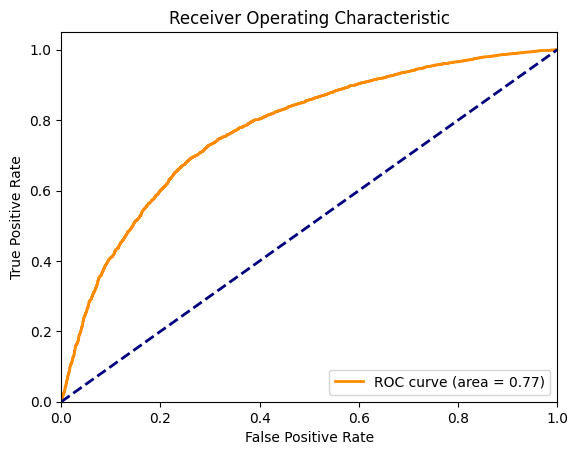

In [ ]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve
import numpy as np
import matplotlib.pyplot as plt

# Calculate accuracy, precision, recall, and F1 score
print(classification_report(true_labels, predictions))
print(f"Accuracy: {accuracy_score(true_labels, predictions)}")

# Calculate the ROC-AUC score and plot the ROC curve
# Assuming your positive class is the second one in the 'class_names'
positive_class_probs = np.array(probs)[:, 1]
roc_auc = roc_auc_score(true_labels, positive_class_probs)

fpr, tpr, _ = roc_curve(true_labels, positive_class_probs)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import torchvision

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

In [ ]:
def visualize_model(model, num_images=6):
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'true: {class_names[labels[j]]} pred: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    return

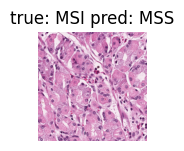

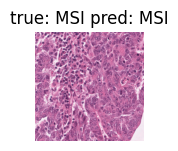

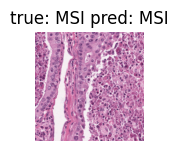

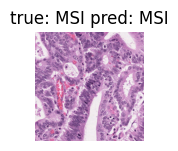

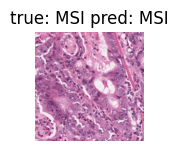

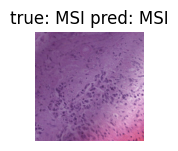

In [ ]:
visualize_model(model, num_images=6)

The predicted class is: MSI
The probability of being MSI is: 91.80%
Red Regions -  highest importance for the predicted class.
Yellow Regions - moderately high importance for the predicted class.


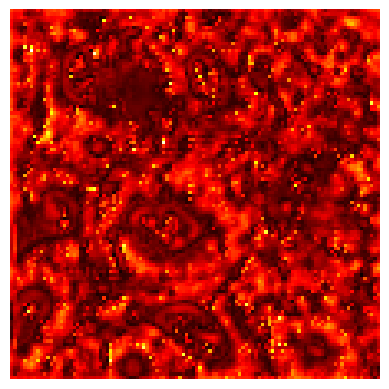

In [ ]:
import torch
import torchvision.transforms as transforms
from PIL import Image

# Check if CUDA (GPU support) is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
PATH = '/content/gdrive/MyDrive/MSI_MSS_PRETRAINED_resnet50_state_dict_3.pth'

#load model
model = models.resnet50(pretrained=False)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
model.load_state_dict(torch.load(PATH, map_location=device))
model = model.to(device)
model.eval()

# Define preprocessing transformations for prediction
data_transforms = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load and preprocess the image for prediction
image_path = '/content/gdrive/MyDrive/MSI_MSS_2/Test_Final/MSI/MSI/MSI_12204.png'
test_image = Image.open(image_path)
input_image = data_transforms(test_image).unsqueeze(0).to(device)  # Add a batch dimension

# Perform inference on the test image
with torch.no_grad():
    outputs = model(input_image)
    probabilities = torch.nn.functional.softmax(outputs, dim=1)  # Softmax to get probabilities
    _, predicted = torch.max(outputs, 1)

# Get the predicted class index and class name
predicted_class_index = predicted.item()
class_names = ['MSI', 'MSS']  # Replace with your class names

predicted_class_name = class_names[predicted_class_index]
predicted_probability = probabilities[0][predicted_class_index].item() * 100  # Probability in percentage

print(f"The predicted class is: {predicted_class_name}")
print(f"The probability of being {predicted_class_name} is: {predicted_probability:.2f}%")

# Set up hooks for guided backpropagation
activation = []

def hook_fn(module, input, output):
    activation.append(output)

for module in model.named_modules():
    if isinstance(module[1], torch.nn.ReLU):
        module[1].register_forward_hook(hook_fn)

# Forward pass
output = model(input_image)
prediction = output.argmax(1)

# Backpropagation to compute gradients
model.zero_grad()
one_hot_output = torch.FloatTensor(1, output.size()[-1]).zero_().to(device)
one_hot_output[0][prediction] = 1
output.backward(gradient=one_hot_output)

# Get the gradients and compute the heatmap
if len(activation) > 0:
    gradients = activation[0][0].detach().cpu().numpy()
    heatmap = gradients.max(axis=0)

    # Apply thresholding to the heatmap
    threshold = 0.5  # Adjust this threshold value as needed
    heatmap[heatmap < threshold] = 0

    # Visualize the heatmap
    # Descriptions of Red and Yellow regions in a heatmap
    print("Red Regions -  highest importance for the predicted class.")
    print("Yellow Regions - moderately high importance for the predicted class.")

    import matplotlib.pyplot as plt

    plt.imshow(heatmap, cmap='hot')
    plt.axis('off')
    plt.show()
else:
    print("No activations recorded.")